In [129]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.502784,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.602571,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.563298,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.560356,0.434710,0.215044,0.535173,0.515598,0.341800,0.578386,0.497830,0.644700,1.0
3992,0.369342,0.453484,0.419993,0.555453,0.659636,0.310077,0.418230,0.518917,0.459890,1.0
3993,0.514873,0.394047,0.550464,0.706030,0.415335,0.544953,0.446907,0.582838,0.610959,1.0
3994,0.500670,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [130]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 1910  0.377486  0.367913  0.177474     0.506338  0.587052      0.532162   
 3640  0.400101  0.467810  0.357472     0.665129  0.721359      0.340118   
 2390  0.502393  0.523948  0.476171     0.679065  0.529611      0.550336   
 3892  0.528345  0.627791  0.290964     0.283096  0.562040      0.444796   
 3116  0.373572  0.468936  0.453992     0.567200  0.809344      0.452684   
 ...        ...       ...       ...          ...       ...           ...   
 1149  0.518453  0.469176  0.401806     0.472982  0.520861      0.342012   
 3869  0.553940  0.689391  0.451435     0.481782  0.639655      0.525932   
 1243  0.320243  0.453230  0.210180     0.385498  0.460753      0.405802   
 2777  0.367250  0.234182  0.180075     0.429726  0.739213      0.233879   
 197   0.399330  0.659287  0.575471     0.597858  0.582265      0.503497   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 1910        0.443423 

In [131]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [132]:
# Naive random forest model

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

print(f'Random Forest test score: {random_forest.score(test_x, test_y):0.2%}')

Random Forest test score: 75.38%


In [133]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': [100, 200],
  'max_depth': [None, 10, 20, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, params, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_

print(f'Random Forest test score: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Random Forest test score: 76.68%


In [134]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f'Best model: {best_model}, best params: {best_params}')
print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=200), best params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best model score: 75.75%


In [135]:
# Perform a manual search to graph the F1 score against the max_depth
from sklearn.metrics import f1_score

max_depths = range(1, 50 + 1)
scores = []


for max_depth in max_depths:
  # print(f'start: {max_depth}')
  params = dict(best_params, max_depth=max_depth)
  random_forest = RandomForestClassifier(**params)
  random_forest.fit(train_x, train_y)
  score = f1_score(test_y, random_forest.predict(test_x))
  scores.append(score)
  # print(f'end: {max_depth}')


# Modify the best params' max_depth accordingly
best_max_depth = max_depths[np.argmax(scores)]
best_params['max_depth'] = best_max_depth

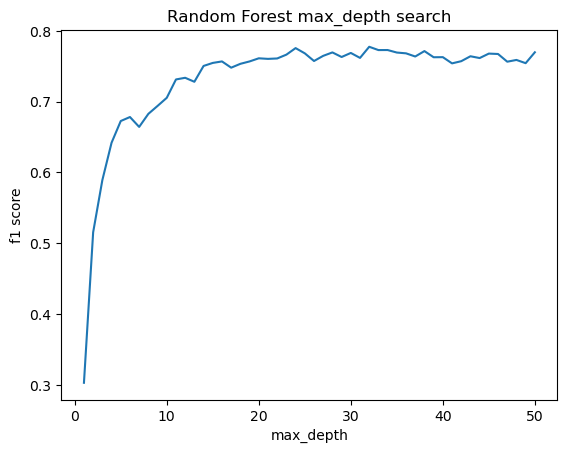

In [136]:
# Plot the search results

plt.plot(max_depths, scores)
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Random Forest max_depth search')

plt.show()

In [137]:
from sklearn.calibration import CalibratedClassifierCV

ideal_rf = RandomForestClassifier(**best_params)

calibrated_rf = CalibratedClassifierCV(ideal_rf, cv=NUM_FOLDS)
calibrated_rf.fit(train_x, train_y)

ideal_rf_prefit = RandomForestClassifier(**best_params)
ideal_rf_prefit.fit(train_x, train_y)

calibrated_rf_prefit = CalibratedClassifierCV(ideal_rf_prefit, cv='prefit')
calibrated_rf_prefit.fit(train_x, train_y)

print(f'Calibrated Random Forest (cv={NUM_FOLDS}) test score: {calibrated_rf.score(test_x, test_y):0.2%}')
print(f'Calibrated Random Forest (cv=prefit) test score: {calibrated_rf_prefit.score(test_x, test_y):0.2%}')

Calibrated Random Forest (cv=5) test score: 75.75%
Calibrated Random Forest (cv=prefit) test score: 74.38%


In [138]:
calibrated_rf.predict_proba(test_x)

array([[0.06931551, 0.93068449],
       [0.44986411, 0.55013589],
       [0.18560201, 0.81439799],
       ...,
       [0.73819713, 0.26180287],
       [0.47945049, 0.52054951],
       [0.63222903, 0.36777097]])

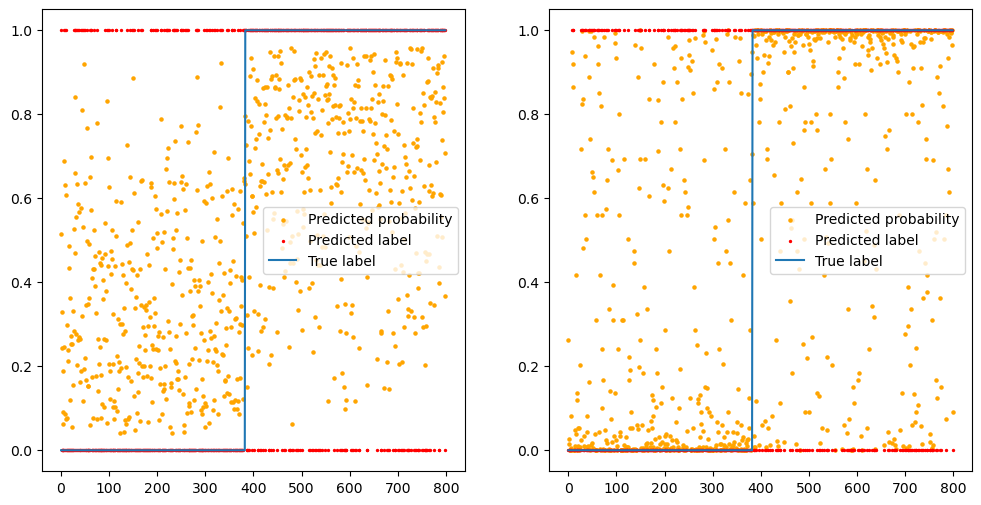

In [139]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((
  calibrated_rf.predict_proba(test_x)[:, 1], 
  calibrated_rf.predict(test_x), 
  calibrated_rf_prefit.predict_proba(test_x)[:, 1],
  calibrated_rf_prefit.predict(test_x),
  test_y
  ))

# Sort by true label
results = results[results[:, -1].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(results)), results[:, 2], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 3], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.show()




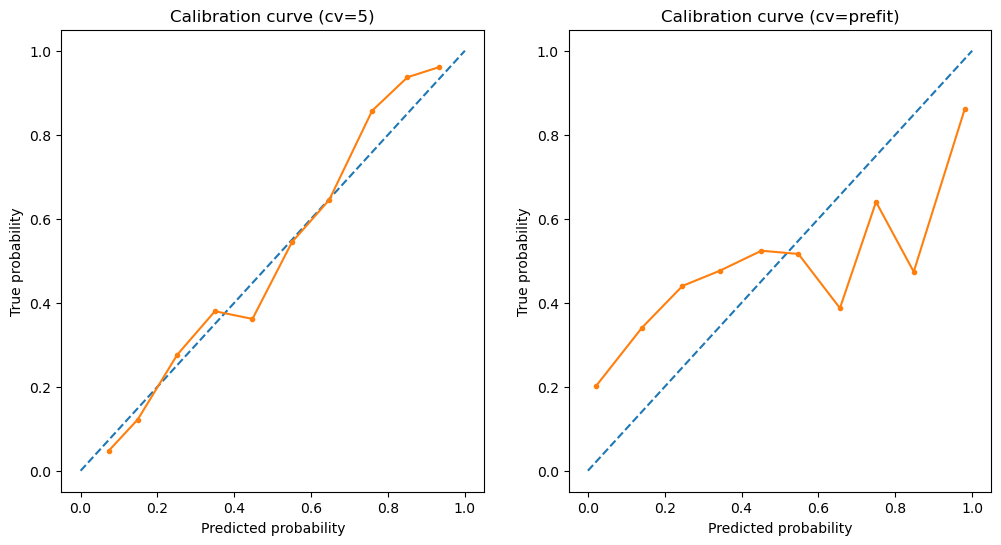

In [140]:
from sklearn.calibration import calibration_curve

# Plot the calibration curve for the two models

plt.figure(figsize=(12, 6))

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=5)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf_prefit.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 2)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=prefit)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

plt.show()